In [14]:
import torch
import os
import PlotModule
import matplotlib.pyplot as plt
from Model.PyTorch_CIFAR10.cifar10_models.resnet import resnet18

model_vanilla = resnet18(pretrained=True)

folder_name = 'Test_2024-10-28_15-32_Resnet18_p0.7'
model_name = 'local_pruned_model.pth'
dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
pruned_model = torch.load(f'{folder_path}/{model_name}')

folder_name = 'Test_2024-10-28_15-32_Resnet18_p0.7'
model_name = '/FineTuning/best_model.pth'
dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
finetuned_model = torch.load(f'{folder_path}/{model_name}')

Min Nonzero Gp (FC): 0.011895670555531979, Min Nonzero Gm (FC): 0.014217847026884556
Min Nonzero Gp (Conv): 1.1238326180773583e-07, Min Nonzero Gm (Conv): 9.361220776327173e-08


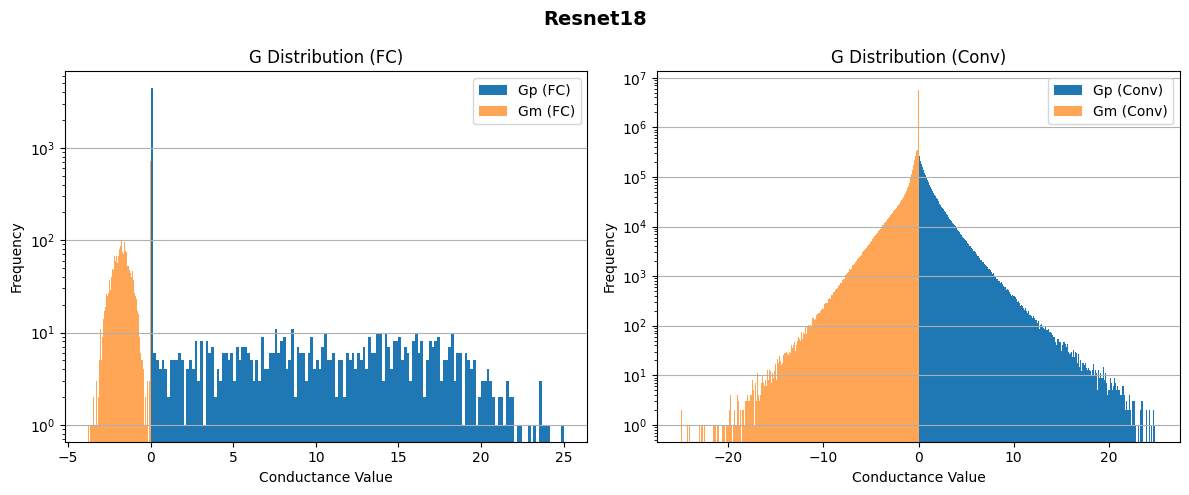

In [2]:
model_vanilla = resnet18(pretrained=True)
PlotModule.plot_conductance_distribution(model_vanilla, 'Resnet18', True, True)

Min Nonzero Gp (FC): 2.2370553016662598, Min Nonzero Gm (FC): 2.2239603996276855
Min Nonzero Gp (Conv): 0.44036930799484253, Min Nonzero Gm (Conv): 0.44036737084388733


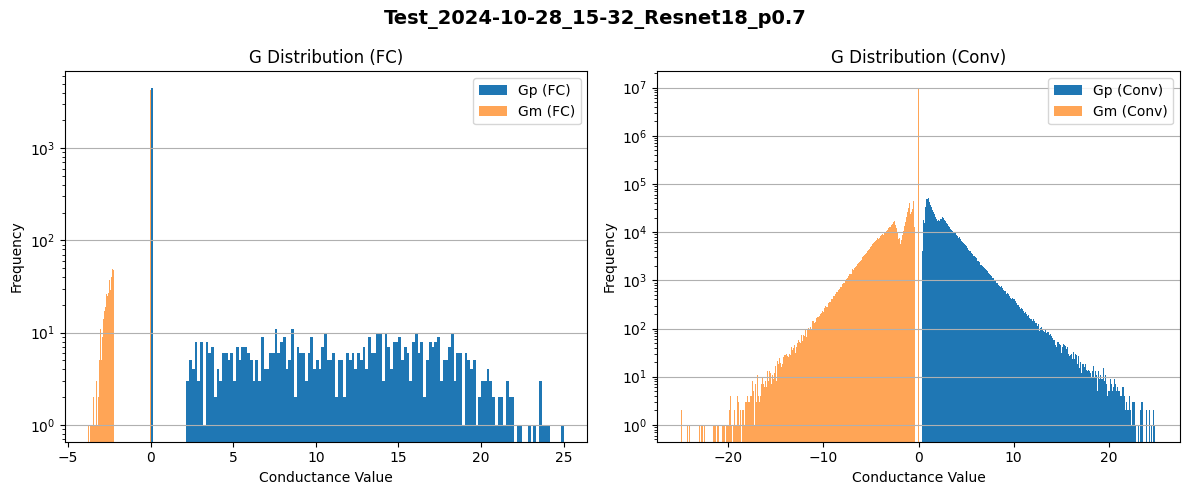

In [4]:
folder_name = 'Test_2024-10-28_15-32_Resnet18_p0.7'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
pruned_model = torch.load(f'{folder_path}/{model_name}')

PlotModule.plot_conductance_distribution(pruned_model, folder_name, True, True)

Min Positive Value: 1.401298464324817e-45, Min Negative Value: -5.605193857299268e-45


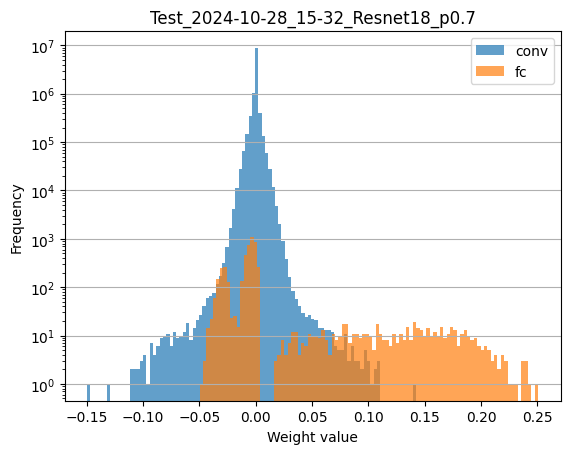

In [6]:
folder_name = 'Test_2024-10-28_15-32_Resnet18_p0.7'
model_name = '/FineTuning/best_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
finetuned_model = torch.load(f'{folder_path}/{model_name}')

PlotModule.plot_weights(finetuned_model, folder_name)

Min Positive Value: 5.520276596948648e-11, Min Negative Value: -3.384727220723249e-11


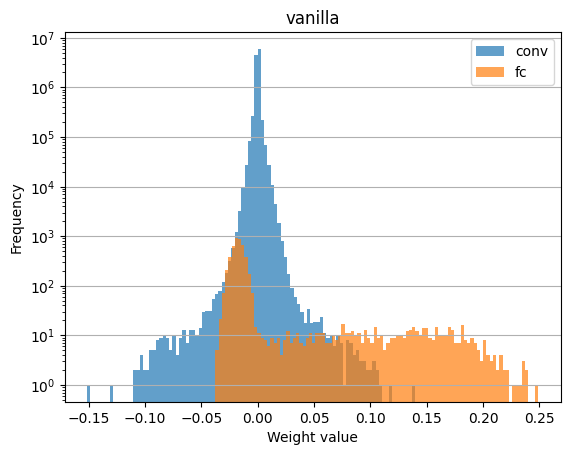

In [ ]:
PlotModule.plot_weights(model_vanilla, 'vanilla')

Min Positive Value: 0.0001375446154270321, Min Negative Value: -0.00013754489191342145


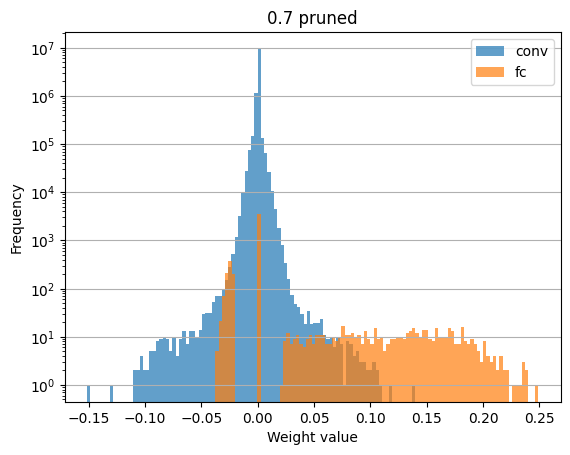

In [9]:
PlotModule.plot_weights(pruned_model, '0.7 pruned')

## 특정 module만 그리기

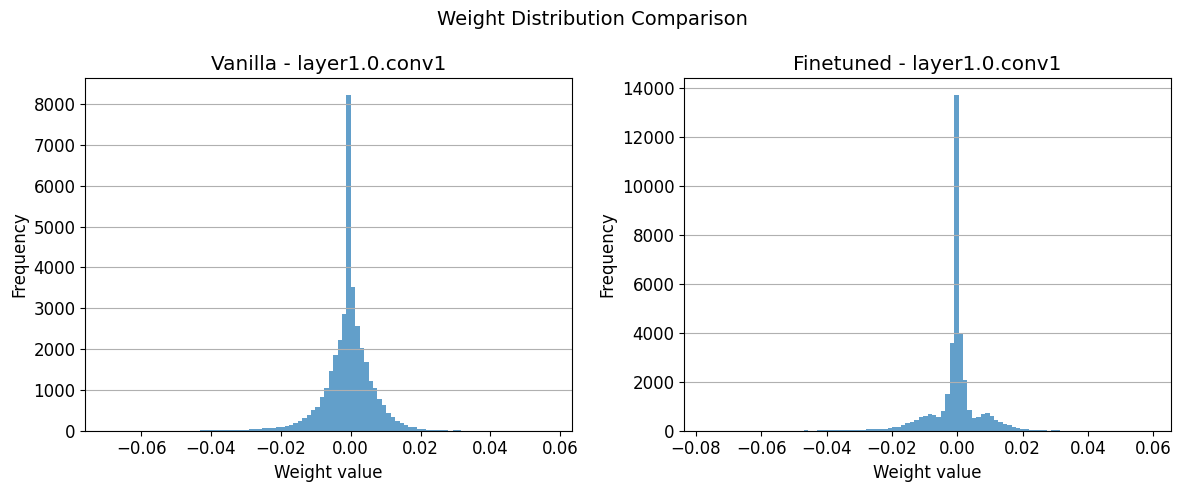

In [15]:
import PlotModule
PlotModule.plot_weight_comparison(model_vanilla, finetuned_model, 'layer1.0.conv1')

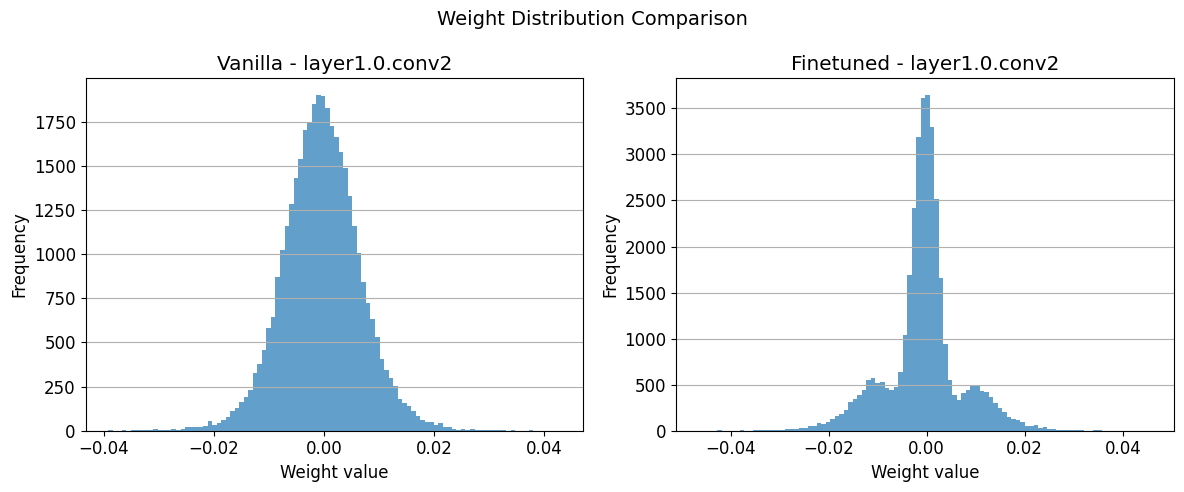

In [16]:
PlotModule.plot_weight_comparison(model_vanilla, finetuned_model, 'layer1.0.conv2')